In [1]:
from queue import Queue
from threading import Thread
boxv=[]
def worker(input_q, output_q):
        print("worker")
        while True:
            if input_q.full():
                print("full break")
                break
            frame = input_q.get()
            box,newframe=detect_objectsbyframe(frame)
            if box is not None:
                print("box",box)

                boxv.append(box)
            
#            if bFind:
#                capturephoto(frame,1000)
            output_q.put("hello")
            print('shape =',frame.shape)
            
        print("worker exit")
input_q = Queue(2)  # fps is better if queue is higher but then more lags
output_q = Queue()
for i in range(1):
        t = Thread(target=worker, args=(input_q, output_q))
        t.daemon = True
        t.start()
print("test")
#input_q.put('hello')

worker
test


In [2]:
import subprocess
import redis
positionv=[]
def addposition(x,y):
        positionv.append((x,y))
    
def isDetect(line):
    return line.startswith("detection=")
def toPosition(line):
      plotline=line[10:]
      plotv=plotline.split(",")
      return plotv
def apriltag(imagename):
#    imagename='/Users/aadebuger/GEXT/cloud2019/machinevision/data/tz_belt_output20190417_5/40.jpg'
    
#    lines=subprocess.getoutput('/Users/aadebuger/GEXT/github2019/apriltags/xcodebuild/Debug/apriltag_demo {0}'.format(imagename))
    lines=subprocess.getoutput('/home/aadebugergf/Ai/cloud2019/apriltags/build/apriltag_demo {0}'.format(imagename))
    linev=lines.split("\n")
    detectionv=filter(lambda item:isDetect(item),linev)
    positionv=map(lambda item:toPosition(item),detectionv)
    return list(positionv)
import numpy as np 
def getBox(plotv):
            arr2=np.asarray(plotv[1:],float)
            rect=(arr2[6],arr2[7],arr2[4]-arr2[0],arr2[1]-arr2[5])
            return (rect[0]+rect[2]/2,rect[1]+rect[3]/2)

def computeposition(x,y):
    yuandian=(853.5124299065,706.912679109)
    kx = -0.8937383178 
    ky = -0.8729680915
    scarax = yuandian[0] + kx*x 
    scaray = yuandian[1] + ky*y
    return (scarax,scaray)
r = redis.Redis(host='localhost', port=6379, db=0)
import base64
#import cStringIO
import sys
import tempfile
import time
MODEL_BASE = '/Users/aadebuger/GEXT/github2019/models/research'
MODEL_BASE = '/home/aadebugergf/Ai/github2019/models/research'


sys.path.append(MODEL_BASE)
sys.path.append(MODEL_BASE + '/object_detection')
sys.path.append(MODEL_BASE + '/slim')


import numpy as np
from PIL import Image
from PIL import ImageDraw
import tensorflow as tf
from utils import label_map_util




PATH_TO_CKPT = '/Users/aadebuger/GEXT/model/ssd_mobilenet_v1_coco_2018_01_28/frozen_inference_graph.pb'
PATH_TO_LABELS = MODEL_BASE + '/object_detection/data/mscoco_label_map.pbtxt'

content_types = {'jpg': 'image/jpeg',
                 'jpeg': 'image/jpeg',
                 'png': 'image/png'}
extensions = sorted(content_types.keys())


def is_image():
  def _is_image(form, field):
    if not field.data:
      raise ValidationError()
    elif field.data.filename.split('.')[-1].lower() not in extensions:
      raise ValidationError()

  return _is_image





class ObjectDetector(object):

  def __init__(self):
    self.detection_graph = self._build_graph()
    self.sess = tf.Session(graph=self.detection_graph)

    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    self.category_index = label_map_util.create_category_index(categories)

  def _build_graph(self):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
      od_graph_def = tf.GraphDef()
      with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    return detection_graph

  def _load_image_into_numpy_array(self, image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

  def detect(self, image):
    image_np = self._load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)

    graph = self.detection_graph
    image_tensor = graph.get_tensor_by_name('image_tensor:0')
    boxes = graph.get_tensor_by_name('detection_boxes:0')
    scores = graph.get_tensor_by_name('detection_scores:0')
    classes = graph.get_tensor_by_name('detection_classes:0')
    num_detections = graph.get_tensor_by_name('num_detections:0')

    (boxes, scores, classes, num_detections) = self.sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

    boxes, scores, classes, num_detections = map(
        np.squeeze, [boxes, scores, classes, num_detections])

    return boxes, scores, classes.astype(int), num_detections
 

def draw_bounding_box_on_image(image, box, color='red', thickness=4):
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  ymin, xmin, ymax, xmax = box
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  if (right-left)<100:
        print("too lower")
        return None
  print("rect,width="+str(right-left)+"height="+str(bottom-top))
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
  print('(left, right, top, bottom)',(left, right, top, bottom))
  centerx=left+(right-left)/2
  centery=top+ (bottom-top)/2
  print("center=",centerx,"y=",centery)
  scaraxy=computeposition(centerx*4/3,centery*4/3)
  print("scara xy",scaraxy)
  return scaraxy
    
from io import BytesIO
def encode_image(image):
  image_buffer = BytesIO()
  image.save(image_buffer, format='PNG')
  imagevalue = image_buffer.getvalue()
  base64str=base64.b64encode(imagevalue).decode()

  imgstr = 'data:image/png;base64,{:s}'.format(
     base64str )
  return imgstr


def detect_objects(image_path):
  start = time.time()
  
  image = Image.open(image_path).convert('RGB')
  boxes, scores, classes, num_detections = client.detect(image)
  end = time.time()
  print("execute1 time",(end-start)) 
    
  image.thumbnail((480, 480), Image.ANTIALIAS)
  print(num_detections)
  new_images = {}
  for i in range(int(num_detections)):
    
    if scores[i] < 0.8: continue
    print("scres[i",scores[i])
    cls = classes[i]
    if cls not in new_images.keys():
      new_images[cls] = image.copy()
    print("boxes",boxes[i])
    draw_bounding_box_on_image(new_images[cls], boxes[i],
                               thickness=int(scores[i]*10)-4)

  result = {}
#  result['original'] = encode_image(image.copy())
#  print(new_images)
  count = 0 
  for cls, new_image in new_images.items():
    category = client.category_index[cls]['name']
    print(category)
    result[category] = encode_image(new_image)
    new_image.save("{0}.jpg".format(count))
    count=count+1
  end = time.time()
  print("execute2 time",(end-start)) 
  return result

def detect_objectsbyframe(frame):
  start = time.time()
  
#  image = Image.open(image_path).convert('RGB')
  height, width, channels = frame.shape
  image= Image.frombytes("RGB", (width,height), frame.tostring())
  boxes, scores, classes, num_detections = client.detect(image)
  end = time.time()
#  print("execute1 time",(end-start)) 
    
  image.thumbnail((480, 480), Image.ANTIALIAS)
#  print(num_detections)
  new_images = {}
  
  for i in range(int(num_detections)):

    if scores[i] < 0.8: continue
    print("scres[i",scores[i])
    cls = classes[i]
    if cls not in new_images.keys():
      new_images[cls] = image.copy()
    print("boxes",boxes[i])
    box=draw_bounding_box_on_image(new_images[cls], boxes[i],
                               thickness=int(scores[i]*10)-4)
    if box is not None:
        print("scarxbox",box)
        return (box,new_images[cls])
    return (None,None)
#  result['original'] = encode_image(image.copy())
#  print(new_images)
  return (None,None)


PATH_TO_CKPT='/Users/aadebuger/GEXT/model/ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03/frozen_inference_graph.pb'
PATH_TO_CKPT='/home/aadebugergf/Ai/models/ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03/frozen_inference_graph.pb'


PATH_TO_CKPT='/home/aadebugergf/Ai/models/fastrcnnstbmodelrtx2/frozen_inference_graph.pb'
client = ObjectDetector()

In [1]:
import ipywidgets as widgets
belttestposition=(520.0,364.36,-90,-90,'皮带视频测试点')
belttestendposition=(235.00,364.36,-90,-90,'皮带测试结束点')
import cv2
cap = cv2.VideoCapture('/home/aadebugergf/aixgf/tzimagedata/beltvideo/belt_output2019053102.mp4')
ret, frame = cap.read()
img_str = cv2.imencode('.jpg', frame)[1].tostring()
import time
start = time.time()
image1=widgets.Image(
    value=img_str,
    format='jpg',
    width=300,
    height=400,
)
display(image1)

button1=widgets.Button(
    description='Click me',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check'
)
bExit=False
ivalue=0
def capturephoto(frame,count):
    
    cv2.imwrite("/home/aadebugergf/aixgf/tzimagedata/beltvision/object{0}.jpg".format(count),frame)

def on_button_clicked(b):
    global bExit
    global ivalue
    print("Button clicked.",bExit)
    bExit=True
    ivalue=10
    print(time.time())
def isExit1():
    global bExit
    return bExit
button1.on_click(on_button_clicked)
display(button1)

boxv=[]
def videooutput():
    global ivalue
    bFirst=False
    count = 0 
    while(True):
        ret, frame = cap.read()
        if frame is None:
            break
        if bFirst is False:
            input_q.put(frame)
            bFirst = True
        if output_q.empty():
                pass
        else:
                data=output_q.get()
                bFirst=False
        img_str = cv2.imencode('.jpg', frame)[1].tostring()

        image1.value=img_str
        end = time.time()
        time.sleep(0.033)
        if ( (end-start)>60):
            break
videooutput()
cap.release()
print("capture end")

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

Button(description='Click me', icon='check', style=ButtonStyle(), tooltip='Click me')

NameError: name 'input_q' is not defined

In [ ]:
import ipywidgets as widgets
belttestposition=(520.0,364.36,-90,-90,'皮带视频测试点')
belttestendposition=(235.00,364.36,-90,-90,'皮带测试结束点')
import cv2
cap = cv2.VideoCapture('/home/aadebugergf/aixgf/tzimagedata/beltvideo/belt_output2019062600.mp4')
ret, frame = cap.read()
img_str = cv2.imencode('.jpg', frame)[1].tostring()
import time
start = time.time()
image1=widgets.Image(
    value=img_str,
    format='jpg',
    width=300,
    height=400,
)
display(image1)

button1=widgets.Button(
    description='Click me',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check'
)
bExit=False
ivalue=0
def capturephoto(frame,count):
    
    cv2.imwrite("/home/aadebugergf/aixgf/tzimagedata/beltvision/object{0}.jpg".format(count),frame)

def on_button_clicked(b):
    global bExit
    global ivalue
    print("Button clicked.",bExit)
    bExit=True
    ivalue=10
    print(time.time())
def isExit1():
    global bExit
    return bExit
button1.on_click(on_button_clicked)
display(button1)

def videooutput():
    global ivalue
    bFirst=False
    count = 0 
    while(True):
        ret, frame = cap.read()
        if frame is None:
            break
        if bFirst is False:
            input_q.put(frame)
            bFirst = True
        if output_q.empty():
                pass
        else:
                data=output_q.get()
                bFirst=False
        img_str = cv2.imencode('.jpg', frame)[1].tostring()

        image1.value=img_str
        end = time.time()
        time.sleep(0.033)
        if ( (end-start)>60):
            break
videooutput()
cap.release()
print("capture end")

In [ ]:
import ipywidgets as widgets
belttestposition=(520.0,364.36,-90,-90,'皮带视频测试点')
belttestendposition=(235.00,364.36,-90,-90,'皮带测试结束点')
import cv2
cap = cv2.VideoCapture('/home/aadebugergf/aixgf/tzimagedata/beltvideo/belt_output2019062600.mp4')
ret, frame = cap.read()
img_str = cv2.imencode('.jpg', frame)[1].tostring()
import time
image1=widgets.Image(
    value=img_str,
    format='jpg',
    width=300,
    height=400,
)
display(image1)

button1=widgets.Button(
    description='Click me',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check'
)
bExit=False
ivalue=0
def capturephoto(frame,count):
    
    cv2.imwrite("/home/aadebugergf/aixgf/tzimagedata/beltvision/object{0}.jpg".format(count),frame)

def on_button_clicked(b):
    global bExit
    global ivalue
    print("Button clicked.",bExit)
    bExit=True
    ivalue=10
    print(time.time())
def isExit1():
    global bExit
    return bExit
button1.on_click(on_button_clicked)
display(button1)

def videooutput():
    global ivalue
    bFirst=False
    count = 0 
    start = time.time()
    while(True):
        ret, frame = cap.read()
        if frame is None:
            print("frame none")
            break
        if bFirst is False:
            start1=time.time()
            input_q.put(frame)
            bFirst = True
        if output_q.empty():
                pass
        else:
                data=output_q.get()
                end1=time.time()
                print("detect time",(end1-start1))
                bFirst=False
        img_str = cv2.imencode('.jpg', frame)[1].tostring()

        image1.value=img_str
        end = time.time()
        if ( (end-start)>60):
            print("time ok")
            break
videooutput()
cap.release()
print("capture end")

In [ ]:
import ipywidgets as widgets
belttestposition=(520.0,364.36,-90,-90,'皮带视频测试点')
belttestendposition=(235.00,364.36,-90,-90,'皮带测试结束点')
import cv2
cap = cv2.VideoCapture('/home/aadebugergf/aixgf/tzimagedata/beltvideo/belt_output2019062600.mp4')
ret, frame = cap.read()
img_str = cv2.imencode('.jpg', frame)[1].tostring()
import time
image1=widgets.Image(
    value=img_str,
    format='jpg',
    width=300,
    height=400,
)
display(image1)

button1=widgets.Button(
    description='Click me',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check'
)
bExit=False
ivalue=0
def capturephoto(frame,count):
    
    cv2.imwrite("/home/aadebugergf/aixgf/tzimagedata/beltvision/object{0}.jpg".format(count),frame)

def on_button_clicked(b):
    global bExit
    global ivalue
    print("Button clicked.",bExit)
    bExit=True
    ivalue=10
    print(time.time())
def isExit1():
    global bExit
    return bExit
button1.on_click(on_button_clicked)
display(button1)

def videooutput():
    global ivalue
    bFirst=False
    count = 0 
    start = time.time()
    while(True):
        ret, frame = cap.read()
        if frame is None:
            print("frame none")
            break
        if bFirst is False:
            start1=time.time()
            input_q.put(frame)
            bFirst = True
        if output_q.empty():
                pass
        else:
                data=output_q.get()
                end1=time.time()
                print("detect time",(end1-start1))
                bFirst=False
        img_str = cv2.imencode('.jpg', frame)[1].tostring()

        image1.value=img_str
        end = time.time()
        if ( (end-start)>60):
            print("time ok")
            break
videooutput()
cap.release()
print("capture end")

In [ ]:
import ipywidgets as widgets
belttestposition=(520.0,364.36,-90,-90,'皮带视频测试点')
belttestendposition=(235.00,364.36,-90,-90,'皮带测试结束点')
import cv2
cap = cv2.VideoCapture(1)
ret, frame = cap.read()
img_str = cv2.imencode('.jpg', frame)[1].tostring()
import time
image1=widgets.Image(
    value=img_str,
    format='jpg',
    width=300,
    height=400,
)
display(image1)

button1=widgets.Button(
    description='Click me',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check'
)
bExit=False
ivalue=0
def capturephoto(frame,count):
    
    cv2.imwrite("/home/aadebugergf/aixgf/tzimagedata/beltvision/object{0}.jpg".format(count),frame)

def on_button_clicked(b):
    global bExit
    global ivalue
    print("Button clicked.",bExit)
    bExit=True
    ivalue=10
    print(time.time())
def isExit1():
    global bExit
    return bExit
button1.on_click(on_button_clicked)
display(button1)

def videooutput():
    global ivalue
    bFirst=False
    count = 0 
    start = time.time()
    while(True):
        ret, frame = cap.read()
        if frame is None:
            print("frame none")
            break
        if bFirst is False:
            start1=time.time()
            input_q.put(frame)
            bFirst = True
        if output_q.empty():
                pass
        else:
                data=output_q.get()
                end1=time.time()
                print("detect time",(end1-start1))
                bFirst=False
        img_str = cv2.imencode('.jpg', frame)[1].tostring()

        image1.value=img_str
        end = time.time()
        if ( (end-start)>60):
            print("time ok")
            break
videooutput()
cap.release()
print("capture end")

In [13]:
import pandas as pd
boxf = pd.DataFrame(boxv)
boxf.describe()

,0,1
count,170.000000,170.000000
mean,629.203775,346.115092
std,3.391242,0.815296
min,625.184167,344.214021
25%,626.960792,345.569134
50%,627.502882,346.027983
75%,631.276886,346.494778
max,636.602750,349.123704


In [17]:
import ipywidgets as widgets
belttestposition=(520.0,364.36,-90,-90,'皮带视频测试点')
belttestendposition=(235.00,364.36,-90,-90,'皮带测试结束点')
import cv2
cap = cv2.VideoCapture(1)
ret, frame = cap.read()
img_str = cv2.imencode('.jpg', frame)[1].tostring()
import time
image1=widgets.Image(
    value=img_str,
    format='jpg',
    width=300,
    height=400,
)
display(image1)

button1=widgets.Button(
    description='Click me',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check'
)
bExit=False
ivalue=0
def capturephoto(frame,count):
    
    cv2.imwrite("/home/aadebugergf/aixgf/tzimagedata/beltvision/object{0}.jpg".format(count),frame)

def on_button_clicked(b):
    global bExit
    global ivalue
    print("Button clicked.",bExit)
    bExit=True
    ivalue=10
    print(time.time())
def isExit1():
    global bExit
    return bExit
button1.on_click(on_button_clicked)
display(button1)
boxv=[]
def videooutput():
    global ivalue
    bFirst=False
    count = 0 
    start = time.time()
    while(True):
        ret, frame = cap.read()
        if frame is None:
            print("frame none")
            break
        if bFirst is False:
            start1=time.time()
            input_q.put(frame)
            bFirst = True
        if output_q.empty():
                pass
        else:
                data=output_q.get()
                end1=time.time()
                print("detect time",(end1-start1))
                bFirst=False
        img_str = cv2.imencode('.jpg', frame)[1].tostring()

        image1.value=img_str
        end = time.time()
        if ( (end-start)>60):
            print("time ok")
            break
videooutput()
cap.release()
print("capture end")

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

Button(description='Click me', icon='check', style=ButtonStyle(), tooltip='Click me')

shape = (480, 640, 3)
detect time 1.332360029220581
shape = (480, 640, 3)
detect time 0.31970715522766113
shape = (480, 640, 3)
detect time 0.3199315071105957
shape = (480, 640, 3)
detect time 0.3197469711303711
shape = (480, 640, 3)
detect time 0.27985644340515137
shape = (480, 640, 3)
detect time 0.27976250648498535
shape = (480, 640, 3)
detect time 0.31998252868652344
shape = (480, 640, 3)
detect time 0.2836441993713379
shape = (480, 640, 3)
detect time 0.3200502395629883
shape = (480, 640, 3)
detect time 0.28006720542907715
shape = (480, 640, 3)
detect time 0.3201267719268799
shape = (480, 640, 3)
detect time 0.2845587730407715
shape = (480, 640, 3)
detect time 0.28089046478271484
shape = (480, 640, 3)
detect time 0.32000160217285156
shape = (480, 640, 3)
detect time 0.3200104236602783
shape = (480, 640, 3)
detect time 0.28353452682495117
shape = (480, 640, 3)
detect time 0.28130006790161133
shape = (480, 640, 3)
detect time 0.32010793685913086
shape = (480, 640, 3)
detect time 0.3

scres[i 0.99794334
boxes [0.7446163  0.03934813 1.         0.24562831]
too lower
shape = (480, 640, 3)
detect time 0.3196859359741211
scres[i 0.9911748
boxes [0.747605   0.04036465 1.         0.24613486]
too lower
shape = (480, 640, 3)
detect time 0.3199343681335449
scres[i 0.9987348
boxes [0.74547595 0.05603041 1.         0.26422703]
too lower
shape = (480, 640, 3)
detect time 0.32002973556518555
scres[i 0.99814534
boxes [0.7401389  0.05739089 0.9963722  0.27397814]
rect,width=103.961883187294height=92.24400043487549
(left, right, top, bottom) (27.54762589931488, 131.5095090866089, 266.44999980926514, 358.6940002441406)
center= 79.52856749296188 y= 312.5720000267029
scara xy (758.7421257355619, 343.09216934946835)
scarxbox (758.7421257355619, 343.09216934946835)
box (758.7421257355619, 343.09216934946835)
shape = (480, 640, 3)
detect time 0.2796180248260498
scres[i 0.9973117
boxes [0.7360649  0.06540431 0.9945471  0.2854135 ]
rect,width=105.60441255569458height=93.05359840393066
(left

scres[i 0.9970547
boxes [0.72793156 0.2516549  0.99636734 0.473804  ]
rect,width=106.63156986236572height=96.63687944412231
(left, right, top, bottom) (120.79434871673584, 227.42591857910156, 262.05536127090454, 358.69224071502686)
center= 174.1101336479187 y= 310.3738009929657
scara xy (646.0338992952679, 345.65077950309325)
scarxbox (646.0338992952679, 345.65077950309325)
box (646.0338992952679, 345.65077950309325)
shape = (480, 640, 3)
detect time 0.3197312355041504
scres[i 0.99807787
boxes [0.73030275 0.26089448 0.99644166 0.4772409 ]
rect,width=103.8462781906128height=95.81000804901123
(left, right, top, bottom) (125.22934913635254, 229.07562732696533, 262.9089903831482, 358.7189984321594)
center= 177.15248823165894 y= 310.8139944076538
scara xy (642.4084741381704, 345.1384130962784)
scarxbox (642.4084741381704, 345.1384130962784)
box (642.4084741381704, 345.1384130962784)
shape = (480, 640, 3)
detect time 0.32003331184387207
scres[i 0.9958073
boxes [0.73263973 0.27535534 0.991772

scres[i 0.9916584
boxes [0.72826403 0.43689063 0.99369    0.6533293 ]
rect,width=103.8905668258667height=95.55335283279419
(left, right, top, bottom) (209.70750331878662, 313.5980701446533, 262.1750521659851, 357.7284049987793)
center= 261.65278673171997 y= 309.9517285823822
scara xy (541.7136012914473, 346.1420538320824)
scarxbox (541.7136012914473, 346.1420538320824)
box (541.7136012914473, 346.1420538320824)
shape = (480, 640, 3)
detect time 0.2835657596588135
scres[i 0.9950376
boxes [0.7312147  0.44394547 0.9911077  0.663034  ]
rect,width=105.16250610351562height=93.5614800453186
(left, right, top, bottom) (213.09382438659668, 318.2563304901123, 263.23729276657104, 356.79877281188965)
center= 265.6750774383545 y= 310.01803278923035
scara xy (536.9204341849804, 346.06487855620156)
scarxbox (536.9204341849804, 346.06487855620156)
box (536.9204341849804, 346.06487855620156)
shape = (480, 640, 3)
detect time 0.32003188133239746
scres[i 0.99080944
boxes [0.727983   0.45489416 0.99207133

scres[i 0.99769455
boxes [0.71971864 0.6088903  0.9933319  0.8323302 ]
rect,width=107.25116729736328height=98.50077867507935
(left, right, top, bottom) (292.26734161376953, 399.5185089111328, 259.09870862960815, 357.5994873046875)
center= 345.8929252624512 y= 308.3490979671478
scara xy (441.3287483558543, 348.0074476848299)
scarxbox (441.3287483558543, 348.0074476848299)
box (441.3287483558543, 348.0074476848299)
shape = (480, 640, 3)
detect time 0.3198831081390381
scres[i 0.9975326
boxes [0.7296004  0.62672466 0.9984552  0.84063095]
rect,width=102.67501831054688height=96.78772687911987
(left, right, top, bottom) (300.82783699035645, 403.5028553009033, 262.65615463256836, 359.44388151168823)
center= 352.1653461456299 y= 311.0500180721283
scara xy (433.85421117096666, 344.86369159237825)
scarxbox (433.85421117096666, 344.86369159237825)
box (433.85421117096666, 344.86369159237825)
shape = (480, 640, 3)
detect time 0.3198714256286621
scres[i 0.99807477
boxes [0.7255914  0.63476723 1.    

In [18]:
import pandas as pd
boxf = pd.DataFrame(boxv)
boxf.describe()

,0,1
count,59.000000,59.000000
mean,594.387073,345.251529
std,104.820073,1.572487
min,429.810085,340.903064
25%,504.901743,344.515229
50%,587.755884,345.518707
75%,678.335736,346.103466
max,789.237613,348.639948


execute1 time 5.31564736366272
200.0
scres[i 0.9989147
boxes [0.48263523 0.7593894  0.7572856  0.92445135]
too lower
bicycle
execute2 time 5.383025407791138
1



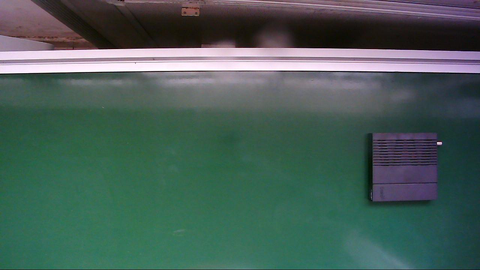

In [3]:
result=detect_objects('/home/aadebugergf/Ai/dataxgf/machinevision/data/belt_output20190624_3/C6.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 0.5729577541351318
200.0
scres[i 0.9989147
boxes [0.48263523 0.7593894  0.7572856  0.92445135]
too lower
bicycle
execute2 time 0.6432681083679199
1



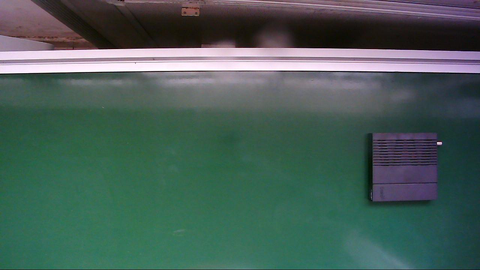

In [4]:
result=detect_objects('/home/aadebugergf/Ai/dataxgf/machinevision/data/belt_output20190624_3/C6.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 0.5621306896209717
200.0
scres[i 0.9989147
boxes [0.48263523 0.7593894  0.7572856  0.92445135]
too lower
bicycle
execute2 time 0.6312265396118164
1



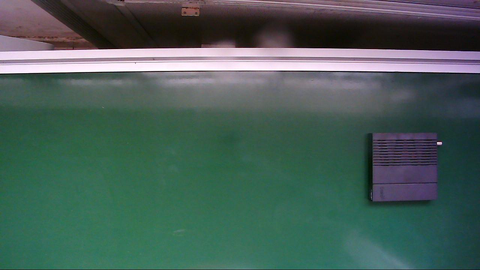

In [5]:
result=detect_objects('/home/aadebugergf/Ai/dataxgf/machinevision/data/belt_output20190624_3/C6.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))